### Importing Modules

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm

from torchvision.utils import make_grid
import numpy as np
import os
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models, transforms, datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Data Downloading


In [ ]:
import tarfile


In [ ]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz

--2023-04-29 17:06:39--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz.3’

maps.tar.gz.3       100%[===================>] 238.65M  4.12MB/s    in 61s     

2023-04-29 17:07:40 (3.90 MB/s) - ‘maps.tar.gz.3’ saved [250242400/250242400]



In [ ]:
tar = tarfile.open('/content/maps.tar.gz',"r:gz")
tar.extractall('/content')

### Generator Model (UNET)

In [ ]:
import torch
import torch.nn as nn
def DoubleConv(in_channel,out_channel):

    conv = nn.Sequential(
        nn.Conv2d(in_channel,out_channel,3,bias = False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel,3, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU(inplace=True)
    )
    return conv
def crop_img(tensor,target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:,:,delta:tensor_size-delta,delta:tensor_size-delta]

class UNET(nn.Module):
    def __init__(self):
        super(UNET,self).__init__()
        self.Maxpool = nn.MaxPool2d(2,2)
        self.enc1 = DoubleConv(1,64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)
        self.enc5 = DoubleConv(512, 1024)

        self.dec1 = nn.ConvTranspose2d(1024,512,2,2)
        self.up_conv1 = DoubleConv(1024,512)
        self.dec2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(512,256)
        self.dec3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(256,128)
        self.dec4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(128,64)
        self.out = nn.Conv2d(64,2,kernel_size=1)



    def forward(self, image):
        l1 = self.enc1(image)

        l2 = self.Maxpool(l1)
        l3 = self.enc2(l2)
        l4 = self.Maxpool(l3)
        l5 = self.enc3(l4)
        l6 = self.Maxpool(l5)
        l7 = self.enc4(l6)
        l8 = self.Maxpool(l7)
        l9 = self.enc5(l8)

        d1 = self.dec1(l9)
        cr = crop_img(l7,d1)

        d1 = self.up_conv1(torch.cat([d1,cr],1))

        d2 = self.dec2(d1)
        cr2 = crop_img(l5, d2)
        d2 = self.up_conv2(torch.cat([d2, cr2], 1))

        d3 = self.dec3(d2)
        cr3 = crop_img(l3, d3)
        d3 = self.up_conv3(torch.cat([d3, cr3], 1))

        d4 = self.dec4(d3)
        cr4 = crop_img(l1, d4)
        d4 = self.up_conv4(torch.cat([d4, cr4], 1))

        out = self.out(d4)
        return out









In [ ]:
from torchsummary import summary

In [ ]:
model = UNET()
summary(model,(1,572,572))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 570, 570]             576
       BatchNorm2d-2         [-1, 64, 570, 570]             128
              ReLU-3         [-1, 64, 570, 570]               0
            Conv2d-4         [-1, 64, 568, 568]          36,864
       BatchNorm2d-5         [-1, 64, 568, 568]             128
              ReLU-6         [-1, 64, 568, 568]               0
         MaxPool2d-7         [-1, 64, 284, 284]               0
            Conv2d-8        [-1, 128, 282, 282]          73,728
       BatchNorm2d-9        [-1, 128, 282, 282]             256
             ReLU-10        [-1, 128, 282, 282]               0
           Conv2d-11        [-1, 128, 280, 280]         147,456
      BatchNorm2d-12        [-1, 128, 280, 280]             256
             ReLU-13        [-1, 128, 280, 280]               0
        MaxPool2d-14        [-1, 128, 1

### Discriminator Model (Patch Gan)

In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self,in_channel = 3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(6,64,4,padding=1,stride=2,padding_mode='reflect'),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False,padding_mode='reflect'),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4,stride=2, padding=1,bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=1,padding=1, bias=False, padding_mode='reflect'),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                512, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            )


        )

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)


        x = self.conv(x)
        return x



In [ ]:
data_dir = "/content/maps"


In [ ]:
data_transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.CenterCrop((256, 512)),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset_train = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=data_transform)
dataset_val = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=data_transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=24, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=24, shuffle=True, num_workers=2)

FileNotFoundError: ignored

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


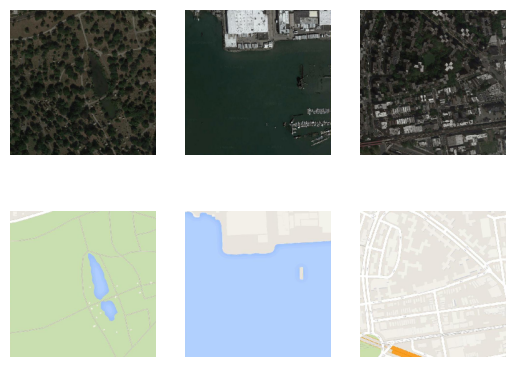

In [ ]:
from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

# load all images in a directory into memory
def load_images(path, size=(256,512)):
	src_list, tar_list = list(), list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# split into satellite and map
		sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(sat_img)
		tar_list.append(map_img)
	return [asarray(src_list), asarray(tar_list)]

# dataset path
path = '/content/maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)


n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

In [ ]:
loss_BCE = nn.BCEWithLogitsLoss()
L1_loss = nn.L1Loss()

### Training

In [ ]:

def train_descriminator(input,target,opt_d):
  opt_d.zero_grad()
  real_pred = Discriminator(input,target)
  real_output = torch.ones(size = real_pred.shape,dtype=torch.float)
  real_loss = loss_BCE(real_pred,real_output)
  real_score = torch.mean(real_pred).item()

  #generate fake images
  fake_img = UNET(input).detach()

  fake_pred = Discriminator(input,fake_img)
  fake_targets = torch.zeros(size= fake_pred.shape,dtype=torch.float)
  fake_loss= loss_BCE(fake_pred,fake_targets)
  fake_score = torch.mean(fake_pred).item()

  loss = (real_loss + fake_loss)//2
  loss.backward()
  opt_d.step()
  return loss



In [ ]:
def train_generator(input,target,opt_g,L1_lamda):
  opt_g.zero_grad()

  generated_image = UNET(input)

  disc_output = Discriminator(input, generated_image)
  desired_output = torch.ones(size=disc_output.shape, dtype=torch.float)

  generator_loss = loss_BCE(disc_output, desired_output) + L1_lamda * torch.abs(generated_image - target).sum()
  generator_loss.backward()
  opt_g.step()

  return generator_loss, generated_image

In [ ]:
L1_lambda = 100
NUM_EPOCHS= 10
lr=0.0002
beta1=0.5
beta2=0.999

opt_d = torch.optim.Adam(Discriminator().parameters(), lr=lr, betas=(beta1, beta2))
opt_g = torch.optim.Adam(UNET().parameters(), lr=lr, betas=(beta1, beta2))

In [ ]:
Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def DeNormalize(tensor_of_image):
  return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]


In [ ]:
def print_images(image_tensor, num_images):

    images = DeNormalize(image_tensor)
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
train_dataset = ''
val_dataset = ''

In [ ]:
dataloader_train = DataLoader(train_dataset,
                        batch_size=64,
                        shuffle=True)
dataloader_val = DataLoader(val_dataset,
                        batch_size=64,
                        shuffle=True)

In [ ]:
for epoch in range(NUM_EPOCHS+1):
    print(f"Training epoch {epoch+1}")
    for images,_ in tqdm(dataloader_train):
       # Splitting the image

       inputs = images[:,:,:,:256]
       targets = images[:,:,:,256:]

       # Train Discriminator

       Disc_Loss = train_descriminator(inputs,targets,opt_d)

       # Train Geneerator
       for i in range(2):
            Gen_Loss, generator_image = train_generator(inputs,targets, opt_g, L1_lambda)

    if (epoch % 5) == 0:
         print_images(inputs,5)
         print_images(generator_image,5)
         print_images(targets,5)


Training epoch 1


NameError: ignored

In [ ]:
test_imgs,_ = next(iter(dataloader_val))


satellite = test_imgs[:,:,:,:256].to(device)
maps = test_imgs[:,:,:,256:].to(device)

gen = generator(satellite)
#gen = gen[0]

satellite = satellite.detach().cpu()
gen = gen.detach().cpu()
maps = maps.detach().cpu()

print_images(satellite,10)
print_images(gen,10)
print_images(maps,10)